In [1]:
from kmer_feature_matrix_pipeline_funcs import *
from filtering_functions import *

df = pd.read_csv('/Users/joesouber/OneDrive - University of Bristol/MSc Data Science/data science mini project/dsmp-2024-group-13/vdjdb_full.txt', sep='\t')
df = pd.DataFrame(df)

df_preprocessed = preprocess_data(df)
df_preprocessed_species = filter_by_species(df_preprocessed)
df_preprocessed_species_min_score = filter_by_minimum_score(df_preprocessed_species)
df_filtered_epitope = filter_by_length_range(df_preprocessed_species_min_score, 'antigen.epitope')
df_done = filter_by_mhc_class(df_preprocessed_species_min_score)

/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_4856/1022910231.py:4: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/joesouber/OneDrive - University of Bristol/MSc Data Science/data science mini project/dsmp-2024-group-13/vdjdb_full.txt', sep='\t')
/Users/joesouber/OneDrive - University of Bristol/MSc Data Science/data science mini project/dsmp-2024-group-13/filtering_functions.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name + '.length'] = df[column_name].apply(len)


In [2]:

# Assuming 'df' is your original DataFrame
min_instances = 5 # Set the minimum number of instances required for inclusion
filtered_df = filter_by_epitope_instances(df_done, label_col='antigen.epitope', min_instances=min_instances)

print(f"Original DataFrame had {len(df_done)} rows.")
print(f"Filtered DataFrame has {len(filtered_df)} rows.")
print(f"unique epitopes in the filtered DataFrame: {filtered_df['antigen.epitope'].value_counts()}")
print(f"Number of unique epitopes in the filtered DataFrame: {filtered_df['antigen.epitope'].nunique()}")

Original DataFrame had 1385 rows.
Filtered DataFrame has 1058 rows.
unique epitopes in the filtered DataFrame: NLVPMVATV        301
GILGFVFTL        185
GLCTLVAML         61
YLQPRTFLL         58
QYIKWPWYI         51
RPRGEVRFL         44
KLVALGINAV        39
ELAGIGILTV        22
SPRWYFYYL         21
CINGVCWTV         21
DATYQRTRALVR      20
VAANIVLTV         15
EAAGIGILTV        15
EPLPQGQLTAY       15
CVNGSCFTV         14
TAFTIPSI          14
RLPGVLPRA         13
HPVGEADYFEY       11
HMTEVVRHC         11
RLITGRLQSL        10
TLWCSPIKV         10
TPRVTGGGAM         9
LPEPLPQGQLTAY      9
GPRLGVRAT          8
VVMSWAPPV          8
NYNYLYRLF          7
RLARLALVL          7
GADGVGKSAL         7
APRGPHGGAASGL      7
AAGIGILTV          7
FLRGRAYGL          6
SLLMWITQV          6
ALYGFVPVL          6
KLVAMGINAV         5
AAFKRSCLK          5
LLFGYPVYV          5
KLSALGINAV         5
Name: antigen.epitope, dtype: int64
Number of unique epitopes in the filtered DataFrame: 37


/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

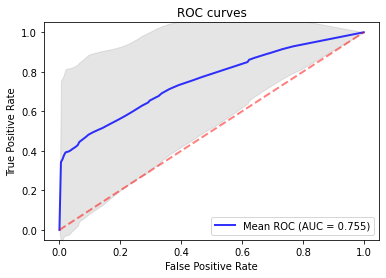

/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

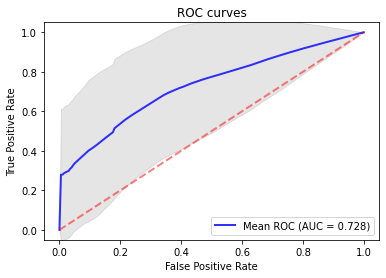

/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

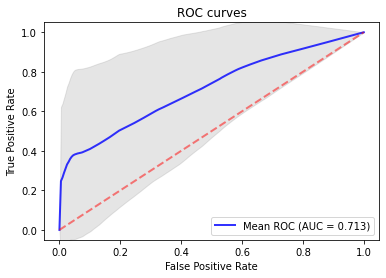

/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

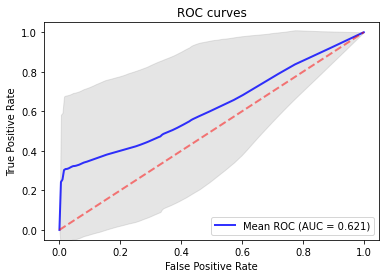

/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

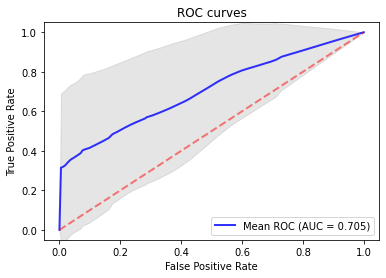

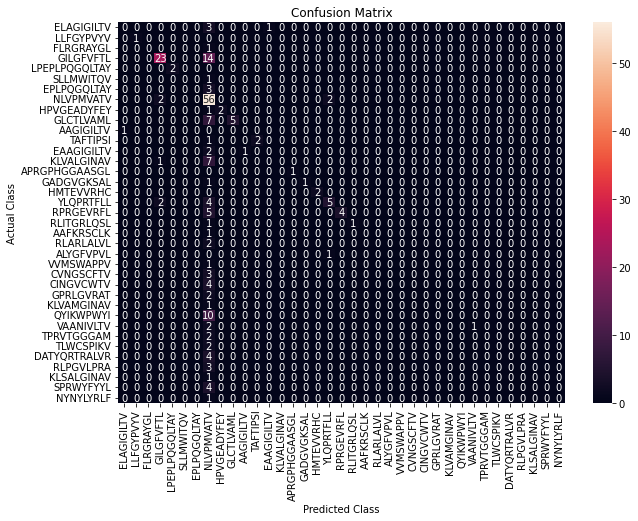

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
X, y, feature_names, kmer_count_dict, epitope_names, epitope_to_int = create_features_matrix(filtered_df, include_alpha=False, include_beta=True, alpha_col='cdr3.alpha', beta_col='cdr3.beta', label_col='antigen.epitope', k=3)
classifier = GradientBoostingClassifier(subsample=0.8,random_state=10, n_estimators=200, learning_rate=0.01, max_features='sqrt', max_depth=7)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
auc_dict, acc_list, precision_list, recall_list, all_class_reports, all_conf_matrices, clf, misclassified_instances, misclassified_details = predict_auc(X, y, rf_classifier, 5, epitope_names, True)


In [9]:
import pandas as pd

# Assuming 'df' is your original DataFrame and 'misclassified_indices' is your list of misclassified indices
misclassified_df = filtered_df.iloc[misclassified_instances]
correctly_classified_df = filtered_df.drop(misclassified_instances)

# Now 'misclassified_df' contains all the rows from your original DataFrame that were misclassified


In [11]:
misclassified_df = pd.DataFrame(misclassified_details, columns=['Index', 'True_Label', 'Predicted_Label'])
g = misclassified_df['Predicted_Label'].value_counts()
h = misclassified_df['True_Label'].value_counts()
g, h

(7     446
 3      43
 17      8
 0       7
 10      5
 12      3
 28      1
 Name: Predicted_Label, dtype: int64,
 3     70
 28    49
 13    39
 17    32
 9     28
 25    21
 35    21
 32    20
 0     20
 18    19
 7     17
 12    15
 24    14
 33    13
 29    13
 11    11
 31    10
 6     10
 23     8
 30     7
 21     7
 36     6
 10     6
 5      6
 26     6
 22     6
 19     6
 27     5
 34     5
 20     5
 8      5
 15     4
 14     3
 2      3
 4      2
 1      1
 Name: True_Label, dtype: int64)

# this shows that when misclassifed the most common epitope predicted label is: NLVPMVATV (the most common epitope), and the most commonly miscalssifed epitope is GILGFVFTL (the second most common epitope)

In [10]:
full_misclassified_df = filtered_df.iloc[misclassified_df['Index']]
full_misclassified_df['True_Label'] = misclassified_df['True_Label']
full_misclassified_df['Predicted_Label'] = misclassified_df['Predicted_Label']
full_misclassified_df


/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_2180/2993012381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_misclassified_df['True_Label'] = misclassified_df['True_Label']
/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_2180/2993012381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_misclassified_df['Predicted_Label'] = misclassified_df['Predicted_Label']


,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,species,mhc.a,mhc.b,antigen.gene,antigen.epitope,vdjdb.score,mhc.class,antigen.epitope.length,True_Label,Predicted_Label
120,CAVRPTSGGSYIPTF,TRAV21*01,TRAJ6*01,CASSYVGNTGELFF,TRBV6-5*01,NaN,TRBJ2-2*01,HomoSapiens,HLA-A*02:01:48,B2M,NY-ESO-1,SLLMWITQV,3,MHCI,9,24.0,7.0
216,CAVSGGGADGLTF,TRAV12-2*01,TRAJ45*01,CASSFLGTGVEQYF,TRBV28*01,NaN,TRBJ2-7*01,HomoSapiens,HLA-A*02:01:48,B2M,MLANA,EAAGIGILTV,3,MHCI,10,19.0,7.0
350,CILRGSGTYKYIF,TRAV26-2*01,TRAJ40*01,CASRIWGGADTQYF,TRBV5-1*01,NaN,TRBJ2-3*01,HomoSapiens,HLA-B*07:02,B2M,UL49,RPRGEVRFL,2,MHCI,9,17.0,7.0
352,CAEGDSWGKLQF,TRAV13-2*01,NaN,CSALRDNYNSPLHF,TRBV20-1*01,NaN,TRBJ1-6*01,HomoSapiens,HLA-B*07:02,B2M,UL49,RPRGEVRFL,2,MHCI,9,17.0,7.0
353,CAAFQGAQKLVF,TRAV13-1*01,NaN,CSALRDNYNSPLHF,TRBV20-1*01,NaN,TRBJ1-6*01,HomoSapiens,HLA-B*07:02,B2M,UL49,RPRGEVRFL,2,MHCI,9,17.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28875,CVGRDTGRRALTF,TRAV10*01,TRAJ5*01,CASSSLTGQSQETQYF,TRBV28*01,NaN,TRBJ2-5*01,HomoSapiens,HLA-B*07:02,B2M,Nucleocapsid,SPRWYFYYL,1,MHCI,9,NaN,NaN
28892,CVVNGRDARLMF,TRAV10*01,TRAJ31*01,CASNPLAGEFTAKNIQYF,TRBV27*01,NaN,TRBJ2-4*01,HomoSapiens,HLA-B*07:02,B2M,Nucleocapsid,SPRWYFYYL,1,MHCI,9,NaN,NaN
28930,CADPNTGNQFYF,TRAV13-2*01,TRAJ49*01,CASSPTDNF,TRBV9*01,NaN,TRBJ2-3*01,HomoSapiens,HLA-B*07:02,B2M,Nucleocapsid,SPRWYFYYL,1,MHCI,9,NaN,NaN
28932,CIVYNKLIF,TRAV26-1*01,TRAJ4*01,CASSEGQGYEQFF,TRBV2*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-A*24:01,B2M,Spike,NYNYLYRLF,1,MHCI,9,NaN,NaN


In [6]:
import pandas as pd



# Create DataFrame
columns = ['Fold'] + epitope_names + ['Micro Average', 'Macro Average']  # Include epitope names and averages
data = []

# Loop over each fold in auc_dict
for fold, scores in auc_dict.items():
    row = [f"Fold {fold}"]  # Start with fold number
    row += [scores.get(epi) for epi in range(len(epitope_names))]  # Append AUC score for each epitope
    row += [scores.get('micro'), scores.get('macro')]  # Append micro and macro AUC scores
    data.append(row)

results_df = pd.DataFrame(data, columns=columns)

# Calculate and append the mean values for each epitope and averages across all folds
mean_scores = ['Average'] + [results_df[epi].mean() for epi in epitope_names] + [results_df['Micro Average'].mean(), results_df['Macro Average'].mean()]
results_df.loc[len(results_df)] = mean_scores  # Add mean scores as the last row

# Display the DataFrame
results_df




,Fold,ELAGIGILTV,LLFGYPVYV,FLRGRAYGL,GILGFVFTL,LPEPLPQGQLTAY,SLLMWITQV,EPLPQGQLTAY,NLVPMVATV,HPVGEADYFEY,...,VAANIVLTV,TPRVTGGGAM,TLWCSPIKV,DATYQRTRALVR,RLPGVLPRA,KLSALGINAV,SPRWYFYYL,NYNYLYRLF,Micro Average,Macro Average
0,Fold 1,0.515459,1.0,1.000000,0.916525,1.000000,0.796209,1.000000,0.816886,1.000000,...,0.437799,0.846429,0.772619,0.632212,0.766667,0.838863,0.471014,0.997630,0.891594,0.756053
1,Fold 2,0.542512,1.0,1.000000,0.883784,1.000000,0.722749,0.737640,0.785855,0.673810,...,0.820574,0.766667,0.903571,0.445913,0.483333,0.300948,0.822115,0.811905,0.880422,0.728252
2,Fold 3,0.840745,1.0,1.000000,0.904402,0.317536,0.333333,0.992823,0.759649,0.971429,...,0.578947,1.000000,0.742857,0.596154,0.692185,0.367299,0.612981,0.984524,0.879256,0.713191
3,Fold 4,0.401570,1.0,0.352381,0.827120,0.659091,0.350000,0.612981,0.791913,1.000000,...,0.294872,0.959330,0.510766,0.809179,0.454327,0.316667,0.724034,0.269048,0.856458,0.621079
4,Fold 5,0.490338,1.0,0.340476,0.867195,1.000000,0.307143,0.838942,0.762252,0.736378,...,0.658654,0.954545,0.711722,0.521135,0.637019,0.321429,0.439614,1.000000,0.877917,0.705369
5,Average,0.558125,1.0,0.738571,0.879805,0.795325,0.501887,0.836477,0.783311,0.876323,...,0.558169,0.905394,0.728307,0.600919,0.606706,0.429041,0.613952,0.812621,0.877129,0.704789


In [7]:
import pandas as pd
unique_epitope_count = filtered_df['antigen.epitope'].value_counts().to_dict()
# Assuming 'results_df' is your DataFrame with the average AUC scores for each epitope and 'unique_epitope_count' is a dictionary with epitope counts.
# Convert the dictionary to a DataFrame
epitope_counts_df = pd.DataFrame(list(unique_epitope_count.items()), columns=['Epitope', 'Count'])

# Extract the average AUC scores for each epitope from results_df
average_auc_scores = results_df.iloc[-1, 1:-2]  # Exclude 'Fold', 'Micro Average', and 'Macro Average' columns
average_auc_scores = pd.DataFrame(average_auc_scores).reset_index()
average_auc_scores.columns = ['Epitope', 'Average AUC']

# Merge the AUC scores with the counts
combined_df = pd.merge(average_auc_scores, epitope_counts_df, on='Epitope')


In [8]:
# Check data types
print(combined_df.dtypes)

# Convert 'Count' and 'Average AUC' to numeric if they are not
combined_df['Count'] = pd.to_numeric(combined_df['Count'], errors='coerce')
combined_df['Average AUC'] = pd.to_numeric(combined_df['Average AUC'], errors='coerce')

# Calculate correlation again
correlation = combined_df['Count'].corr(combined_df['Average AUC'])
print(f"Correlation between epitope count and AUC score: {correlation}")




Epitope        object
Average AUC    object
Count           int64
dtype: object
Correlation between epitope count and AUC score: 0.21692161758773082


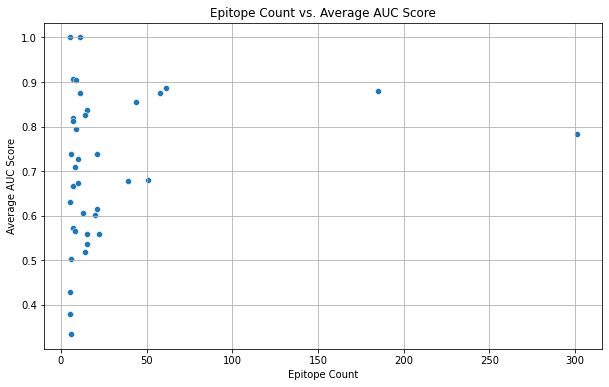

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Count', y='Average AUC', data=combined_df)
plt.title('Epitope Count vs. Average AUC Score')
plt.xlabel('Epitope Count')
plt.ylabel('Average AUC Score')
plt.grid(True)
plt.show()


IndexError: index 32 is out of bounds for axis 0 with size 32

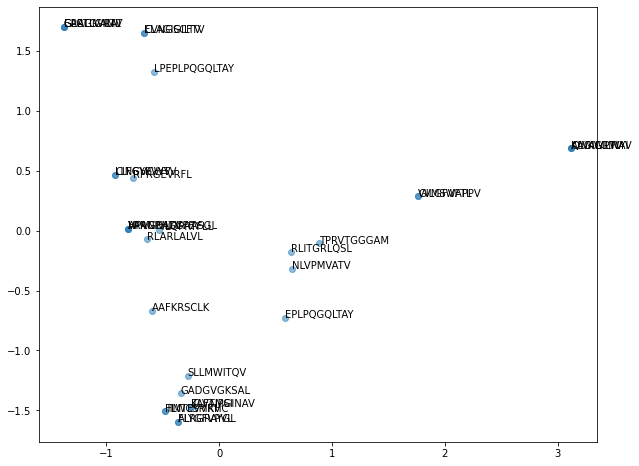

In [20]:
# Assuming 'results_df' is your DataFrame and the last row contains average scores:
average_auc_scores = results_df.iloc[-1]  # This accesses the last row assuming it's the average

# Assuming the column names are correctly set to epitope names and the last two columns are 'Micro Average' and 'Macro Average'
epitope_columns = results_df.columns[:-2]  # This excludes 'Micro Average' and 'Macro Average'

# Ensure the AUC scores are in numeric format
average_auc_scores = pd.to_numeric(average_auc_scores, errors='coerce')

# Recalculate high and low performers using the numeric scores
high_threshold = 0.9
low_threshold = 0.6
high_performers = average_auc_scores[average_auc_scores > high_threshold].index.tolist()
low_performers = average_auc_scores[average_auc_scores < low_threshold].index.tolist()


# Assuming you have a mapping of labels to their respective epitope names already set up
int_to_epitope = {v: k for k, v in epitope_to_int.items()}
epitope_labels = [int_to_epitope.get(label, 'Unknown') for label in y]

# Create masks based on these lists
high_mask = np.isin(epitope_labels, high_performers)
low_mask = np.isin(epitope_labels, low_performers)

# Filter the original feature matrix X based on these masks
X_high = X[high_mask]
X_low = X[low_mask]

def perform_pca_and_plot(data, epitope_names, title):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    plt.figure(figsize=(10, 8))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)

    # Annotate data points with epitope names
    for i, epitope_name in enumerate(epitope_names):
        plt.annotate(epitope_name, (principal_components[i, 0], principal_components[i, 1]))

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.grid(True)
    plt.show()


    

# Perform PCA on high and low performer subsets
perform_pca_and_plot(X_high, epitope_names, 'PCA Plot with Epitope Labels')

#perform_pca_and_plot(X_low, 'PCA of Low Performers')


In [21]:
low_performers

['ELAGIGILTV',
 'SLLMWITQV',
 'EAAGIGILTV',
 'RLARLALVL',
 'ALYGFVPVL',
 'VVMSWAPPV',
 'CVNGSCFTV',
 'KLVAMGINAV',
 'VAANIVLTV',
 'KLSALGINAV']